In [1]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

In [2]:
# updated function -- verified 12/27/2023

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
G = nx.les_miserables_graph()
df = nx.to_pandas_edgelist(G)[['source', 'target']] # cut the weights, for visualization
G = nx.from_pandas_edgelist(df)

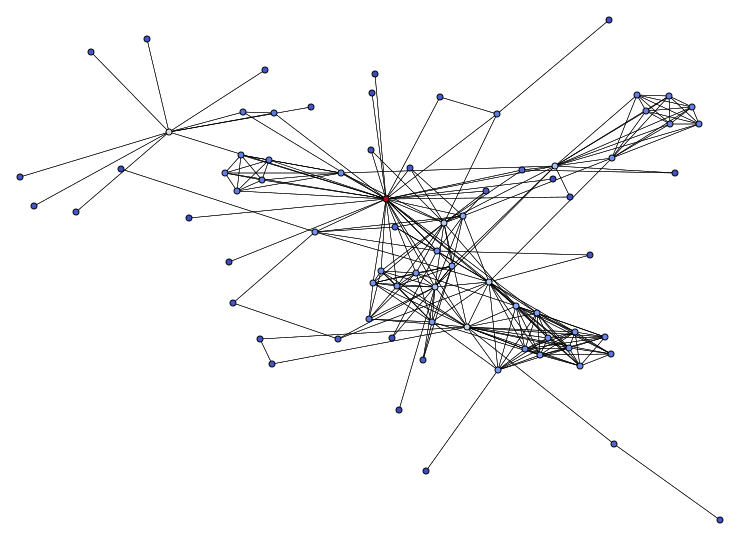

In [4]:
# this is the social network from Les Miserables without names

draw_graph(G, node_size=3)

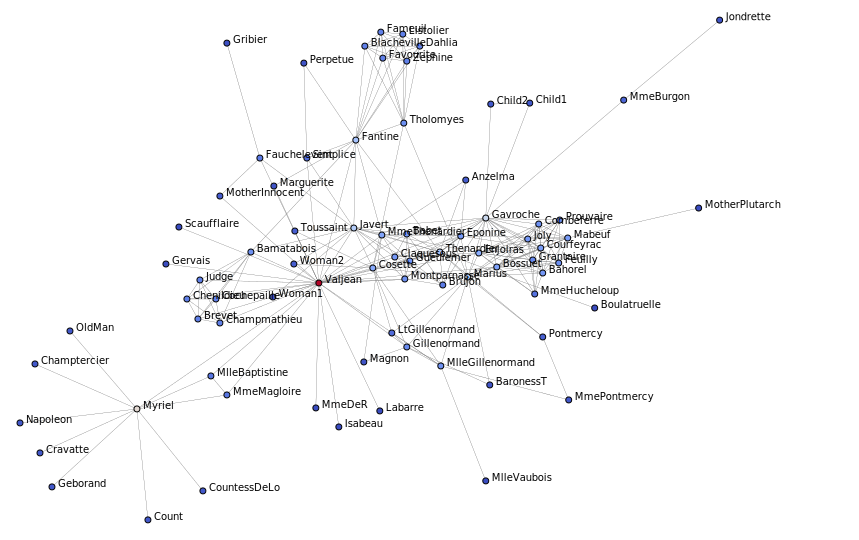

In [5]:
# with names

draw_graph(G, node_size=3, show_names=True, edge_width=0.2)

# Centralities / Importances

I most often hear of these as centralities, but I have heard them called importances as well. Regardless of what you call them, the point is to identify important nodes based on some criteria. Centralities give us a way to IMMEDIATELY pull insights out of any graph. They are a quick path to valuable insights.

- Degree Centrality: Importance based on the number of degrees (edges)
- Betweenness Centrality: Importance based on whether a node sits between other nodes; Information flows through them. Can also be gatekeepers. They have power.
- Closeness Centrality: Importance based on a nodes closeness to other nodes. Has to do with number of steps away.
- PageRank: Importance based on number of inbound and outbound edges. Inbound is more important than outbound.
- There are many, many, others: https://networkx.org/documentation/stable/reference/algorithms/centrality.html

In this notebook, I will show how to use the above, as well as another algorithm called HITS, which is used to identify hubs (many outbound edges) and authorities (many inbound edges).

These are what I consider "starting centralities", in that I always use them, for any graph, to get a lay of the land, so to speak. However, use will depend on the scale of the network. If you are below million scale, then all of these should work, but betweenness and closeness will gradually slow down to the point of being impractical. If you are above million scale, PageRank will be your go-to algorithm. PageRank was created by the founders of Google and it scales well. Betweenness and Closeness Centrality do not scale well, but they are very useful on smaller networks, or on subsets of networks.

# Degree Centrality

In [10]:
deg_cent = nx.degree_centrality(G)

deg_cent_df = pd.DataFrame().from_dict(deg_cent, orient='index')
deg_cent_df.columns = ['degree_centrality']
deg_cent_df.sort_values('degree_centrality', ascending=False, inplace=True)
deg_cent_df.head(10)

,degree_centrality
Valjean,0.473684
Gavroche,0.289474
Marius,0.250000
Javert,0.223684
Thenardier,0.210526
Fantine,0.197368
Enjolras,0.197368
Bossuet,0.171053
Courfeyrac,0.171053
Joly,0.157895


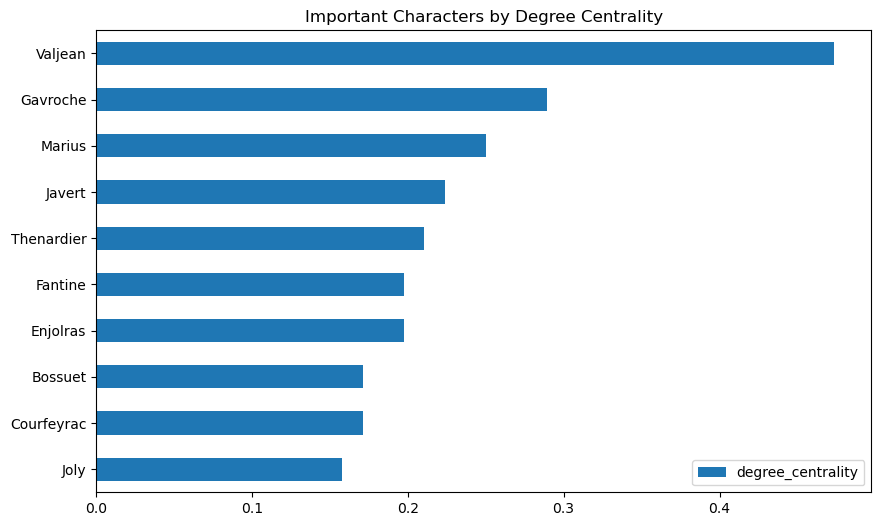

In [11]:
title = 'Important Characters by Degree Centrality'

deg_cent_df.head(10).plot.barh(figsize=(10,6), title=title).invert_yaxis()

# Betweenness Centrality

In [12]:
betw_cent = nx.betweenness_centrality(G)

betw_cent_df = pd.DataFrame().from_dict(betw_cent, orient='index')
betw_cent_df.columns = ['betweenness_centrality']
betw_cent_df.sort_values('betweenness_centrality', ascending=False, inplace=True)
betw_cent_df.head(10)

,betweenness_centrality
Valjean,0.569989
Myriel,0.176842
Gavroche,0.165113
Marius,0.132032
Fantine,0.129645
Thenardier,0.074901
Javert,0.054332
MlleGillenormand,0.047599
Enjolras,0.042553
Tholomyes,0.040629


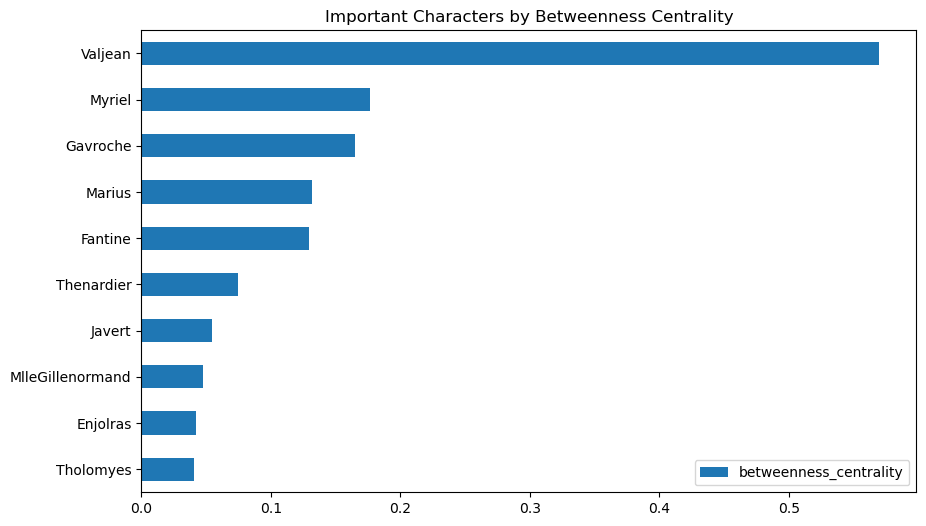

In [13]:
title = 'Important Characters by Betweenness Centrality'

betw_cent_df.head(10).plot.barh(figsize=(10,6), title=title).invert_yaxis()

# Closeness Centrality

In [14]:
close_cent = nx.closeness_centrality(G)

close_cent_df = pd.DataFrame().from_dict(close_cent, orient='index')
close_cent_df.columns = ['closeness_centrality']
close_cent_df.sort_values('closeness_centrality', ascending=False, inplace=True)
close_cent_df.head(10)

,closeness_centrality
Valjean,0.644068
Marius,0.531469
Javert,0.517007
Thenardier,0.517007
Gavroche,0.513514
Enjolras,0.481013
Cosette,0.477987
Bossuet,0.475000
Babet,0.463415
Gueulemer,0.463415


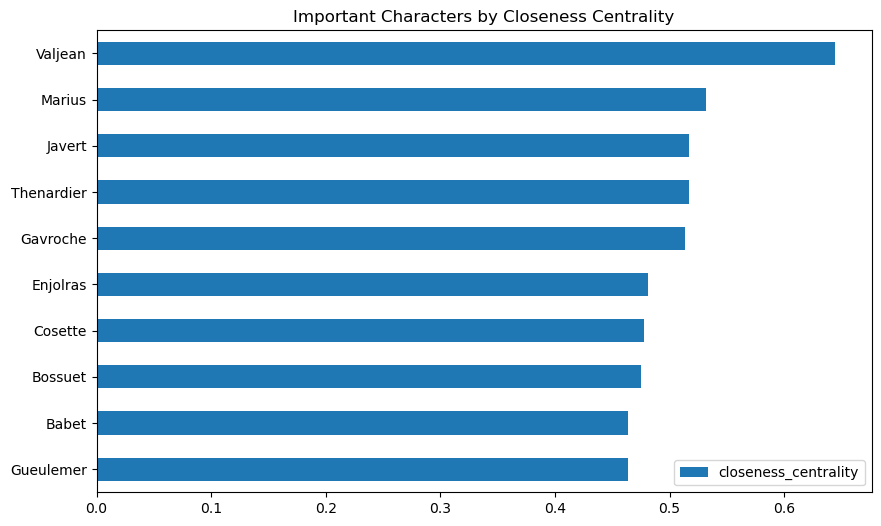

In [15]:
title = 'Important Characters by Closeness Centrality'

close_cent_df.head(10).plot.barh(figsize=(10,6), title=title).invert_yaxis()

# PageRank

In [16]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Valjean,0.075434
Myriel,0.042803
Gavroche,0.035764
Marius,0.030893
Javert,0.030303
Thenardier,0.027926
Fantine,0.027022
Enjolras,0.021880
Cosette,0.020611
MmeThenardier,0.019501


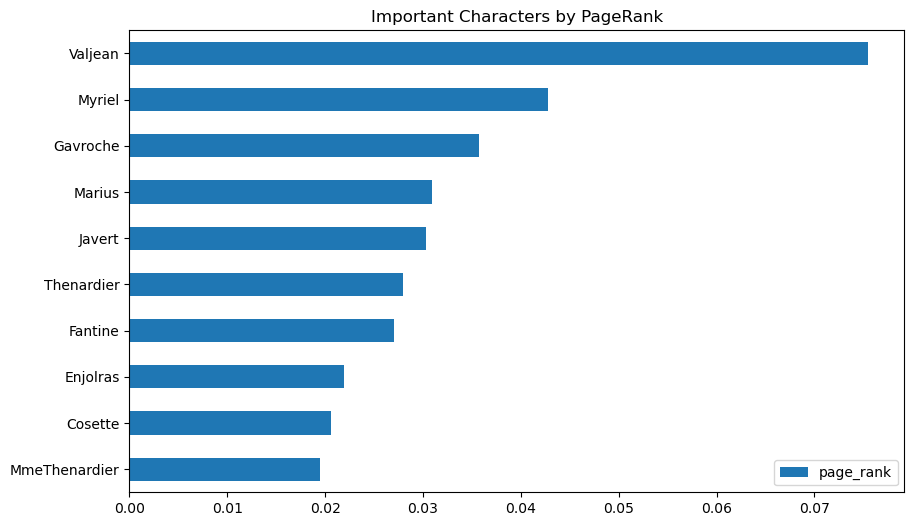

In [17]:
title = 'Important Characters by PageRank'

pr_df.head(10).plot.barh(figsize=(10,6), title=title).invert_yaxis()

# HITS
This algorithm is most useful on directed networks. We will discuss directed vs. undirected very soon. The hits algorithm is a little different, as it returns both hubs and authorities. Hubs have many outbound edges, and authorities have many inbound edges. This example network is undirected, so this algorithm will be less useful, but this is how it works.

In [18]:
hubs, authorities = nx.hits(G)

In [19]:
hub_df = pd.DataFrame().from_dict(hubs, orient='index')
hub_df.columns = ['hub_score']
hub_df.sort_values('hub_score', ascending=False, inplace=True)
hub_df.head(10)

,hub_score
Gavroche,0.052901
Valjean,0.044540
Enjolras,0.044470
Marius,0.043126
Bossuet,0.040301
Courfeyrac,0.038693
Bahorel,0.036876
Joly,0.036876
Combeferre,0.035076
Feuilly,0.035076


In [20]:
authority_df = pd.DataFrame().from_dict(authorities, orient='index')
authority_df.columns = ['authority_score']
authority_df.sort_values('authority_score', ascending=False, inplace=True)
authority_df.head(10)

,authority_score
Gavroche,0.052901
Valjean,0.044540
Enjolras,0.044470
Marius,0.043126
Bossuet,0.040301
Courfeyrac,0.038693
Bahorel,0.036876
Joly,0.036876
Combeferre,0.035076
Feuilly,0.035076


Because this network is undirected, hubs and authories are identical. If we had used a directed graph, the two result sets would be different and insightful. In this case, where we have an undirected network, either one of these sets can be used as a centrality, but I would recomment using Page Rank or one of the other centrality algorithms. 

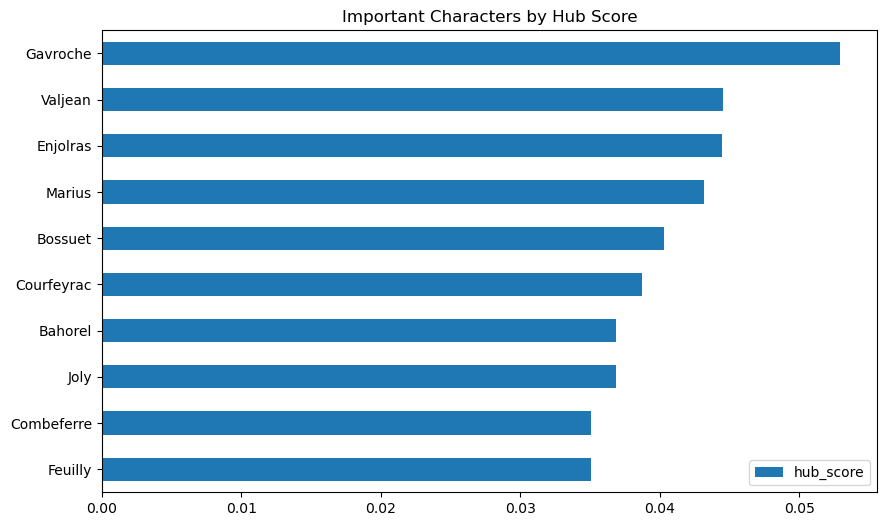

In [21]:
title = 'Important Characters by Hub Score'

hub_df.head(10).plot.barh(figsize=(10,6), title=title).invert_yaxis()

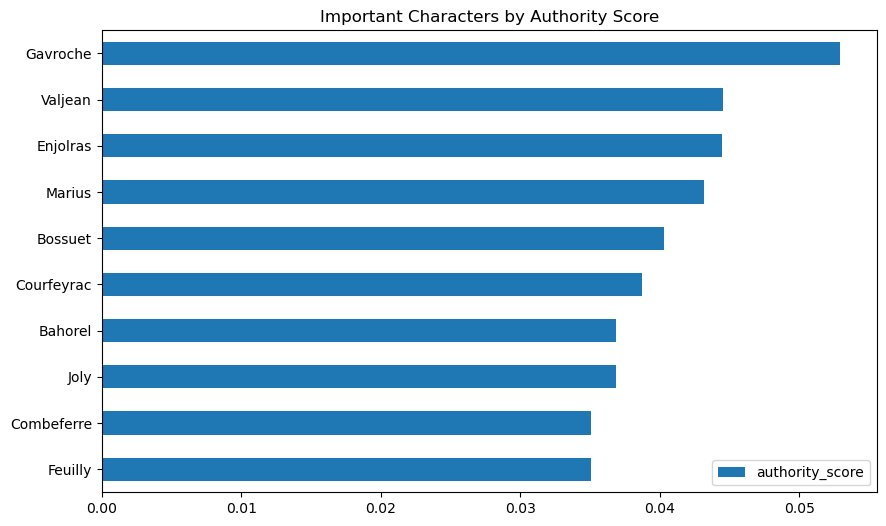

In [22]:
title = 'Important Characters by Authority Score'

authority_df.head(10).plot.barh(figsize=(10,6), title=title).invert_yaxis()

We will explore HITS more, later, with a directed network. It is a very useful algorithm for directed networks.